# Exercises: Recurrent Neural Networks

## Read the data

In [7]:
nov_path = 'kaijin_nijumenso.txt'

with open(nov_path, 'r') as f:
    nov_text = f.read()

## Preprocessiong

In [8]:
import re

text = re.sub("《[^》]+》", "", nov_text)  # remove <brackets>
text = re.sub("［[^］]+］", "", text) # remove [brackets]
text = re.sub("[｜ 　]", "", text) # remove | and spaces

## Setting up the hyperparameters

In [9]:
n_rnn = 20 # number of characters to consider
batch_size = 256 # number of sequences to consider at once
n_epochs = 100 # number of epochs to train for
n_hidden = 256 # number of hidden units in the RNN

## word2vec

In [10]:
import numpy as np

# create a index to character mapping
chars = list(set(text))
char_indices = {c: i for i, c in enumerate(chars)}
indices_char = {i: c for i, c in enumerate(chars)}

# cut the text in semi-redundant sequences of n_rnn characters
time_chars = []
next_chars = []
for i in range(0, len(text) - n_rnn):
    time_chars.append(text[i: i + n_rnn])
    next_chars.append(text[i + n_rnn])

# create a vectorized representation of the sequences
X = np.zeros((len(time_chars), n_rnn, len(chars)), dtype=np.bool)
y = np.zeros((len(time_chars), len(chars)), dtype=np.bool)
for i, time_char in enumerate(time_chars):
    for t, char in enumerate(time_char):
        X[i, t, char_indices[char]] = 1
    y[i, char_indices[next_chars[i]]] = 1

<ipython-input-10-d37885ac7414>:16: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X = np.zeros((len(time_chars), n_rnn, len(chars)), dtype=np.bool)
<ipython-input-10-d37885ac7414>:17: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y = np.zeros((len(time_chars), len(chars)), dtype=np.bool)


## Creating the model

In [11]:
from keras.models import Sequential
from keras.layers import Dense, GRU

model = Sequential()
model.add(GRU(n_hidden, input_shape=(n_rnn, len(chars))))
model.add(Dense(len(chars), activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 256)               1157376   
                                                                 
 dense (Dense)               (None, 1249)              320993    
                                                                 
Total params: 1,478,369
Trainable params: 1,478,369
Non-trainable params: 0
_________________________________________________________________


## Defining the setence generator function

In [12]:
from keras.callbacks import LambdaCallback
def on_epoch_end(epochs, logs):
    if(epochs == n_epochs-1 or epochs == 0):
        print('----- Generating text after Epoch: %d' % epochs)
        beta = 5 # temperature
        prev_text = text[0: n_rnn] # seed text
        created_text = prev_text

        print('----- Generating with seed: "' + prev_text + '"')
        for i in range(400):
            # one-hot encode the characters
            X_pred = np.zeros((1, n_rnn, len(chars)))
            for t, char in enumerate(prev_text):
                X_pred[0, t, char_indices[char]] = 1.

            # predict the next character
            preds = model.predict(X_pred, verbose=0)[0]
            p_power = np.asarray(preds).astype('float64')
            p_power = p_power ** beta # modify the distribution
            next_index = np.random.choice(len(p_power), p=p_power/np.sum(p_power))
            next_char = indices_char[next_index]

            created_text += next_char
            prev_text = prev_text[1:] + next_char 
        print(created_text)
        print()

# set up the callbacks
epoch_end_callback = LambdaCallback(on_epoch_end=on_epoch_end)

## Training the model

In [13]:
history = model.fit(X, y, batch_size=batch_size, epochs=n_epochs, callbacks=[epoch_end_callback])

Epoch 1/100
429/431 [============================>.] - ETA: 0s - loss: 4.7157----- Generating text after Epoch: 0
----- Generating with seed: "そのころ、東京中の町という町、家という家"
そのころ、東京中の町という町、家という家のです。
「そのです。
「そのです。
「そのです。
「そのです。
「そのです。
「そのです。
「そのです。
「そのです。
「そのです。
「そのです。
「は、そのです。
「そのです。
「そのです。
「そのです。
「そのです。
「そのです。
「そのです。
「そのです。
「そのです。
「そのです。
「そのです。
「そのです。
「そのです。
「そのです。
「そのです。
「そのです。
「そのです。
「そのです。
「そのです。
「そのです。
「そのです。
「そのです。
「そのです。
「そのと、そのです。
「そのです。
「そのです。
「そのです。
「そのです。
「そのです。
「そのです。
「そのです。
「そのです。
「そのです。
「そのです。
「そのです。
「そのです。
「そのです。
「そのです。
「そのです。
「そのです。
「に、そのです。
「そのです。
「そのです。
「そのです。
「そのです。
「そ

431/431 [==============================] - 38s 70ms/step - loss: 4.7134
Epoch 2/100
431/431 [==============================] - 6s 14ms/step - loss: 3.7609
Epoch 3/100
431/431 [==============================] - 6s 15ms/step - loss: 3.3638
Epoch 4/100
431/431 [==============================] - 6s 14ms/step - loss: 3.1432
Epoch 5/100
431/431 [==============================] - 6s 15ms/step - loss: 2.9889
Epoch 6/1

## History

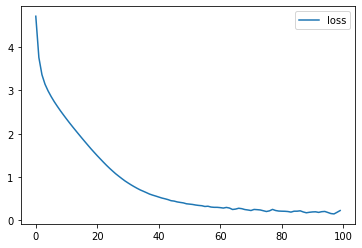

In [14]:
loss = history.history['loss']

import matplotlib.pyplot as plt
plt.plot(loss, label='loss')
plt.legend()
plt.show()